##**DATA PREPARATION**

In [ ]:
# Import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import numpy as np
import pickle
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files

In [ ]:
# Membaca dataset
data = pd.read_csv('netflix_data.csv')

In [ ]:
# Menampilkan informasi dasar
print(data.head())
print(data.info())
print(data.isnull().sum())
print(f"Jumlah data duplikat: {data.duplicated().sum()}")

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

##**DATA CLEANING**

In [ ]:
# Menghapus baris dengan banyak nilai hilang
data_cleaned = data.dropna(thresh=len(data.columns) // 2)

In [ ]:
# Mengisi nilai hilang secara manual
data_cleaned['director'] = data_cleaned['director'].fillna('Unknown')
data_cleaned['cast'] = data_cleaned['cast'].fillna('Unknown')
data_cleaned['country'] = data_cleaned['country'].fillna('Unknown')
data_cleaned['rating'] = data_cleaned['rating'].fillna('Not Rated')
data_cleaned['date_added'] = data_cleaned['date_added'].fillna('Unknown')
data_cleaned['duration'] = data_cleaned['duration'].fillna('Unknown')

In [ ]:
# Cek ulang data setelah pembersihan
print(data_cleaned.isnull().sum())

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


In [ ]:
# Cek jumlah data duplikat
print(f"Jumlah Data Duplikat: {data_cleaned.duplicated().sum()}")

Jumlah Data Duplikat: 0


In [ ]:
# Informasi dataset setelah cleaning
print("Informasi Dataset Setelah Cleaning:")
print(data_cleaned.info())

# Contoh 5 data pertama
print("Contoh 5 Data Pertama:")
print(data_cleaned.head())

Informasi Dataset Setelah Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      8807 non-null   object
 4   cast          8807 non-null   object
 5   country       8807 non-null   object
 6   date_added    8807 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8807 non-null   object
 9   duration      8807 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None
Contoh 5 Data Pertama:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water          Unknown   
2 

##**EXPLORATORY DATA ANALYSIS (EDA)**

<ipython-input-9-12424fc1e49e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, x='type', palette='pastel')


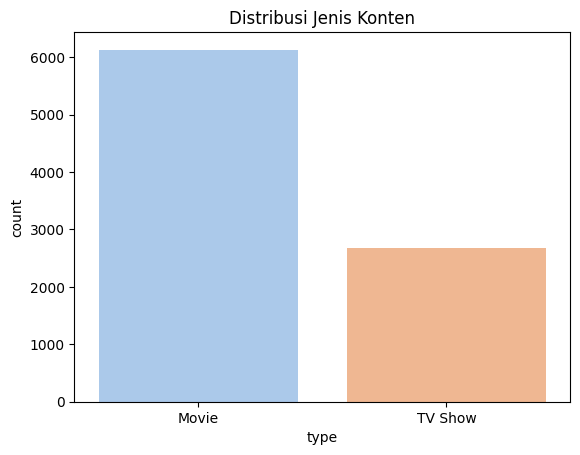

In [ ]:
# 1) Distribusi jenis konten
sns.countplot(data=data_cleaned, x='type', palette='pastel')
plt.title('Distribusi Jenis Konten')
plt.show()

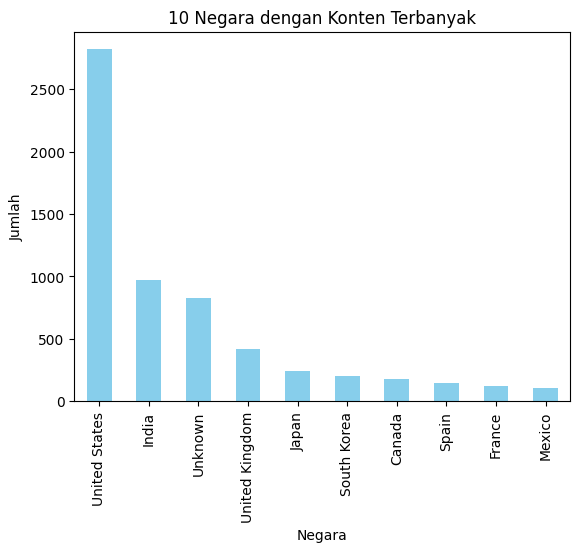

In [ ]:
# 2) Negara dengan jumlah konten terbanyak
top_countries = data_cleaned['country'].value_counts().head(10)
top_countries.plot(kind='bar', color='skyblue')
plt.title('10 Negara dengan Konten Terbanyak')
plt.xlabel('Negara')
plt.ylabel('Jumlah')
plt.show()

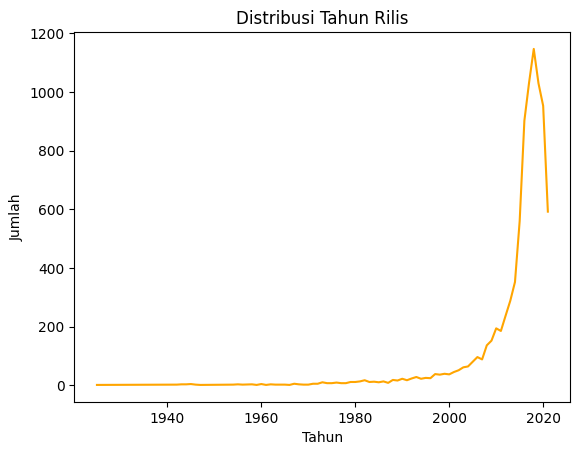

In [ ]:
# 3) Tahun rilis konten
data_cleaned['release_year'].value_counts().sort_index().plot(kind='line', color='orange')
plt.title('Distribusi Tahun Rilis')
plt.xlabel('Tahun')
plt.ylabel('Jumlah')
plt.show()

<ipython-input-12-bcd80a99c683>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x='Count', y='Category', palette='muted')


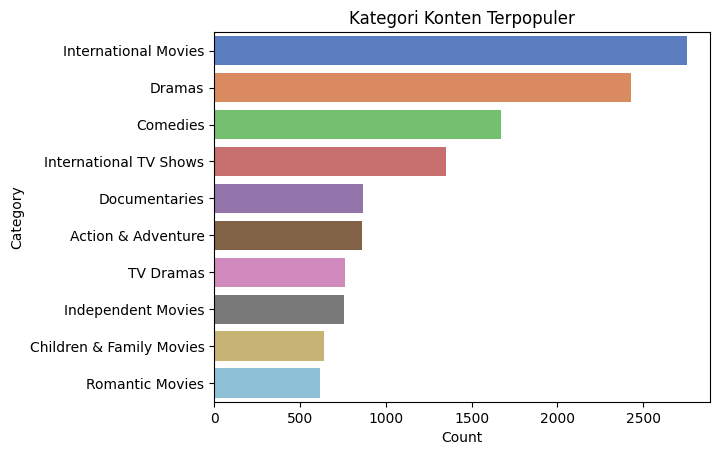

In [ ]:
# 4) Kategori terpopuler
from collections import Counter
categories = Counter([genre for sublist in data_cleaned['listed_in'].dropna().str.split(', ') for genre in sublist])
top_categories = pd.DataFrame(categories.most_common(10), columns=['Category', 'Count'])
sns.barplot(data=top_categories, x='Count', y='Category', palette='muted')
plt.title('Kategori Konten Terpopuler')
plt.show()

<ipython-input-13-0974de3fffcf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, y='rating', order=data_cleaned['rating'].value_counts().index, palette='viridis')


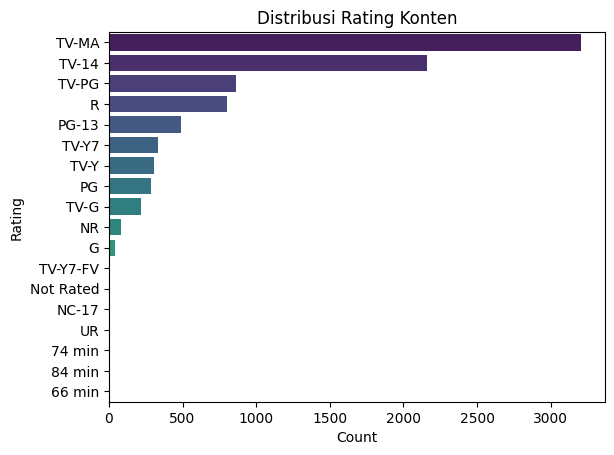

In [ ]:
# 4) Distribusi Rating
sns.countplot(data=data_cleaned, y='rating', order=data_cleaned['rating'].value_counts().index, palette='viridis')
plt.title('Distribusi Rating Konten')
plt.xlabel('Count')
plt.ylabel('Rating')
plt.show()

##**MODEL PREPARATION**

**Feature Engineering**

> Melakukan pembersihan teks untuk penggabungan seluruh informasi ke dalam satu representasi teks (BoW) untuk penghitungan kesamaan yang lebih relevan



In [ ]:
new_data = data_cleaned[['title', 'director', 'cast', 'rating', 'listed_in', 'description']]
new_data.set_index('title', inplace=True)

In [ ]:
new_data.head()

,director,cast,rating,listed_in,description
title,,,,,
Dick Johnson Is Dead,Kirsten Johnson,Unknown,PG-13,Documentaries,"As her father nears the end of his life, filmm..."
Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",TV-MA,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",TV-MA,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
Jailbirds New Orleans,Unknown,Unknown,TV-MA,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",TV-MA,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
class TextCleaner:
    def separate_text(self, texts):
        unique_texts = set()
        for text in texts.split(','):
            unique_texts.add(text.strip().lower())
        return ' '.join(unique_texts)
    def remove_space(self, texts):
        return texts.replace(' ', '').lower()
    def remove_punc(self, texts):
        texts = texts.lower()
        texts = texts.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(texts.split())

In [ ]:
cleaner = TextCleaner()

In [ ]:
new_data['director']    = new_data['director'].apply(cleaner.separate_text)
new_data['cast']        = new_data['cast'].apply(cleaner.separate_text)
new_data['rating']      = new_data['rating'].apply(cleaner.remove_space)
new_data['listed_in']   = new_data['listed_in'].apply(cleaner.separate_text)
new_data['description'] = new_data['description'].apply(cleaner.remove_punc)

<ipython-input-18-0a2d7b306a72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['director']    = new_data['director'].apply(cleaner.separate_text)
<ipython-input-18-0a2d7b306a72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cast']        = new_data['cast'].apply(cleaner.separate_text)
<ipython-input-18-0a2d7b306a72>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [ ]:
new_data.head()

,director,cast,rating,listed_in,description
title,,,,,
Dick Johnson Is Dead,kirsten johnson,unknown,pg-13,documentaries,as her father nears the end of his life filmma...
Blood & Water,unknown,xolile tshabalala greteli fincham dillon windv...,tv-ma,tv mysteries tv dramas international tv shows,after crossing paths at a party a cape town te...
Ganglands,julien leclercq,bakary diombera nabiha akkari samuel jouy trac...,tv-ma,tv action & adventure crime tv shows internati...,to protect his family from a powerful drug lor...
Jailbirds New Orleans,unknown,unknown,tv-ma,reality tv docuseries,feuds flirtations and toilet talk go down amon...
Kota Factory,unknown,revathi pillai arun kumar mayur more ahsaas ch...,tv-ma,romantic tv shows tv comedies international tv...,in a city of coaching centers known to train i...


In [ ]:
new_data['BoW'] = new_data.apply(lambda row: ' '.join(row.dropna().values), axis=1)
new_data.drop(new_data.columns[:-1], axis=1, inplace=True)

<ipython-input-20-cb301f59ffdb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['BoW'] = new_data.apply(lambda row: ' '.join(row.dropna().values), axis=1)
<ipython-input-20-cb301f59ffdb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop(new_data.columns[:-1], axis=1, inplace=True)


In [ ]:
new_data.head()

,BoW
title,
Dick Johnson Is Dead,kirsten johnson unknown pg-13 documentaries as...
Blood & Water,unknown xolile tshabalala greteli fincham dill...
Ganglands,julien leclercq bakary diombera nabiha akkari ...
Jailbirds New Orleans,unknown unknown tv-ma reality tv docuseries fe...
Kota Factory,unknown revathi pillai arun kumar mayur more a...


**TF-IDF Vectorization**

> Sistem rekomendasi ini berbasis content-based filtering menggunakan informasi dari konten untuk memberikan rekomendasi Pendekatan ini menggunakan TfidfVectorizer untuk mengubah data teks dalam kolom Bag of Words (BoW) menjadi representasi vektor numerik.




In [ ]:
tfid = TfidfVectorizer()
tfid_matrix = tfid.fit_transform(new_data['BoW'])
tfid.get_feature_names_out

<bound method CountVectorizer.get_feature_names_out of TfidfVectorizer()>

In [ ]:
tfid_matrix.shape

(8807, 52053)

In [ ]:
tfid_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

##**MODEL PROCESSING**

In [ ]:
cosine_sim = cosine_similarity(tfid_matrix)
cosine_sim

array([[1.        , 0.00711237, 0.02011063, ..., 0.00916939, 0.01970946,
        0.02913693],
       [0.00711237, 1.        , 0.01555672, ..., 0.00103192, 0.        ,
        0.0048199 ],
       [0.02011063, 0.01555672, 1.        , ..., 0.00561843, 0.01044289,
        0.03340176],
       ...,
       [0.00916939, 0.00103192, 0.00561843, ..., 1.        , 0.05542122,
        0.00490945],
       [0.01970946, 0.        , 0.01044289, ..., 0.05542122, 1.        ,
        0.00945413],
       [0.02913693, 0.0048199 , 0.03340176, ..., 0.00490945, 0.00945413,
        1.        ]])

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data_cleaned['title'], columns=data_cleaned['title'])

In [ ]:
print('Shape: ', cosine_sim_df.shape)

Shape:  (8807, 8807)


In [ ]:
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

title,Selfless,XOXO,Ee Nagaraniki Emaindi,Father Soldier Son,Chaahat
title,,,,,
Rolling Papers,0.009205,0.007476,0.001221,0.017781,0.012693
9to5: The Story of a Movement,0.002052,0.011107,0.014916,0.045364,0.016988
A Twelve Year Night,0.005021,0.009913,0.010220,0.012288,0.011108
Al acecho,0.012473,0.007439,0.009764,0.028624,0.013679
Wonder Boy,0.010055,0.010212,0.020578,0.068553,0.022399
Offspring,0.004214,0.015827,0.018721,0.015575,0.017859
Bright,0.028941,0.009985,0.010056,0.020368,0.010032
The Inmate,0.002473,0.008118,0.010041,0.006897,0.008803
"Monster High: Scaris, City of Frights",0.004301,0.002600,0.028967,0.007937,0.011262


In [ ]:
final_data = data_cleaned[['title', 'type', 'director', 'cast', 'rating', 'listed_in', 'description' ]]

In [ ]:
final_data.head()

,title,type,director,cast,rating,listed_in,description
0,Dick Johnson Is Dead,Movie,Kirsten Johnson,Unknown,PG-13,Documentaries,"As her father nears the end of his life, filmm..."
1,Blood & Water,TV Show,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",TV-MA,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,Ganglands,TV Show,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",TV-MA,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,Jailbirds New Orleans,TV Show,Unknown,Unknown,TV-MA,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,Kota Factory,TV Show,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",TV-MA,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
def recommendations(movie_name, similarity_data = cosine_sim_df, items=final_data, k=11):
  index = similarity_data.loc[:,movie_name].to_numpy().argpartition(range(-1, -k, -1))

  closest = similarity_data.columns[index[-1:-(k+2):-1]]

  closest = closest.drop(movie_name, errors='ignore')

  return pd.DataFrame(closest).merge(items).head(k)

##**TESTING MODEL**

Blood & Water

In [ ]:
final_data[final_data.title.eq('Blood & Water')]

,title,type,director,cast,rating,listed_in,description
1,Blood & Water,TV Show,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",TV-MA,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


In [ ]:
recommendations('Blood & Water')

,title,type,director,cast,rating,listed_in,description
0,Diamond City,TV Show,Unknown,"Noxee Maqashalala, Angela Sithole, Nambitha Be...",TV-MA,"Crime TV Shows, International TV Shows, TV Dramas",A prominent prosecuting attorney must defend h...
1,Shirkers,Movie,Sandi Tan,Unknown,TV-14,Documentaries,"In 1992, Sandi Tan and her friends shot a quir..."
2,Kings of Jo'Burg,TV Show,Unknown,"Shona Ferguson, Zolisa Xaluva, Tsholofelo Mats...",TV-MA,"Crime TV Shows, International TV Shows, TV Dramas",The Masire brothers rule Johannesburg's crimin...
3,Lion Pride,TV Show,Unknown,"Yen Tsao, Amanda Chou, Kevin Liu, Peace Yang, ...",TV-MA,"International TV Shows, Romantic TV Shows, TV ...","After crossing paths at a crime scene, a renow..."
4,Frank and Cindy,Movie,G.J. Echternkamp,Unknown,TV-MA,"Documentaries, Music & Musicals",Frank was a rising pop star when he married Ci...
5,Forget Me Not,TV Show,Unknown,Unknown,TV-MA,"International TV Shows, TV Dramas",Teenage Xue Ming was forced to marry the man w...
6,Adam: His Song Continues,Movie,Robert Markowitz,"Daniel J. Travanti, JoBeth Williams, Richard M...",TV-MA,Dramas,"After their child was abducted and murdered, J..."
7,Walk Away from Love,Movie,Christopher Nolen,"Noree Victoria, Brad James, Robert Christopher...",TV-14,"Dramas, Romantic Movies","Heartbroken from her last relationship, an att..."
8,Horrid Henry,TV Show,Unknown,"Lizzie Waterworth, Joanna Ruiz, Emma Tate, Sue...",TV-Y7,"British TV Shows, Kids' TV, TV Comedies","To his family's frustration, Henry is skilled ..."
9,Mom,Movie,Ravi Udyawar,"Sridevi, Akshaye Khanna, Sajal Ali, Nawazuddin...",TV-14,"Dramas, International Movies, Thrillers",After her stepdaughter is sexually assaulted a...


Silver Linings Playbook

In [ ]:
final_data[final_data.title.eq('Silver Linings Playbook')]

,title,type,director,cast,rating,listed_in,description
702,Silver Linings Playbook,Movie,David O. Russell,"Bradley Cooper, Jennifer Lawrence, Robert De N...",R,"Comedies, Dramas, Independent Movies",A man with bipolar disorder moves home with hi...


In [ ]:
recommendations('Silver Linings Playbook')

,title,type,director,cast,rating,listed_in,description
0,Mad World,Movie,Chun Wong,"Shawn Yue, Eric Tsang, Elaine Jin, Charmaine Fong",TV-MA,"Dramas, International Movies",A stockbroker struggling with bipolar disorder...
1,Chris Tucker Live,Movie,Phil Joanou,Chris Tucker,TV-MA,Stand-Up Comedy,"Filmed in his hometown of Atlanta, Chris Tucke..."
2,Jackie Brown,Movie,Quentin Tarantino,"Pam Grier, Samuel L. Jackson, Robert Forster, ...",R,"Dramas, Thrillers",When an aging flight attendant's caught smuggl...
3,The Irishman: In Conversation,Movie,Unknown,"Martin Scorsese, Robert De Niro, Al Pacino, Jo...",TV-MA,Documentaries,Join director Martin Scorsese as he sits down ...
4,An Unfinished Life,Movie,Lasse Hallström,"Robert Redford, Jennifer Lopez, Morgan Freeman...",PG-13,Dramas,A grieving widow and her daughter move in with...
5,Mean Streets,Movie,Martin Scorsese,"Robert De Niro, Harvey Keitel, David Proval, A...",R,"Classic Movies, Dramas, Independent Movies","In New York's Little Italy, a low-level hoodlu..."
6,Lila & Eve,Movie,Charles Stone III,"Viola Davis, Jennifer Lopez, Andre Royo, Shea ...",R,"Dramas, Thrillers","After each of them loses a child to murder, tw..."
7,Like Crazy,Movie,Drake Doremus,"Anton Yelchin, Felicity Jones, Jennifer Lawren...",PG-13,"Dramas, Independent Movies, Romantic Movies",A spirited exchange student and an American ma...
8,The Indian Detective,TV Show,Unknown,"Russell Peters, Anupam Kher, Christina Cole, M...",TV-14,"Crime TV Shows, International TV Shows, TV Com...","In this crime dramedy, a suspended Canadian co..."
9,City of Joy,Movie,Madeleine Gavin,Unknown,TV-MA,Documentaries,Women who've been sexually brutalized in war-t...


Lucifer

In [ ]:
final_data[final_data.title.eq('Lucifer')]

,title,type,director,cast,rating,listed_in,description
82,Lucifer,TV Show,Unknown,"Tom Ellis, Lauren German, Kevin Alejandro, D.B...",TV-14,"Crime TV Shows, TV Comedies, TV Dramas","Bored with being the Lord of Hell, the devil r..."


In [ ]:
recommendations('Lucifer')

,title,type,director,cast,rating,listed_in,description
0,"Rica, Famosa, Latina",TV Show,Unknown,Unknown,TV-MA,"International TV Shows, Reality TV, Spanish-La...",This reality series follows the lives of a gro...
1,Hope Springs Eternal,Movie,Jack C. Newell,"Mia Rose Frampton, Beth Lacke, Stony Blyden, J...",PG,Dramas,When a teen with terminal cancer miraculously ...
2,Monty Python's Fliegender Zirkus,TV Show,Unknown,"Graham Chapman, John Cleese, Eric Idle, Terry ...",TV-MA,"International TV Shows, TV Comedies",The Pythons elevate the absurd to new heights ...
3,On My Block,TV Show,Unknown,"Sierra Capri, Jason Genao, Brett Gray, Diego T...",TV-14,"Romantic TV Shows, TV Comedies, TV Dramas",In a rough inner-city Los Angeles neighborhood...
4,Nightcrawler,Movie,Dan Gilroy,"Jake Gyllenhaal, Rene Russo, Riz Ahmed, Bill P...",R,"Dramas, Independent Movies, Thrillers",A young hustler finds success trolling the str...
5,Marvel's Iron Fist,TV Show,Unknown,"Finn Jones, Jessica Henwick, David Wenham, Jes...",TV-MA,"Crime TV Shows, TV Action & Adventure, TV Dramas",Danny Rand resurfaces 15 years after being pre...
6,Chef,Movie,Jon Favreau,"Jon Favreau, Sofía Vergara, John Leguizamo, Sc...",R,"Comedies, Independent Movies",After igniting a Twitter war with a well-known...
7,Spartacus,TV Show,Unknown,"Andy Whitfield, Liam McIntyre, Dustin Clare, J...",TV-MA,"TV Action & Adventure, TV Dramas",A Thracian man is condemned to a brutal death ...
8,Girlfriends,TV Show,Unknown,"Tracee Ellis Ross, Golden Brooks, Persia White...",TV-14,TV Comedies,Four close friends in Los Angeles challenge an...
9,Wassup Man GO!,TV Show,Unknown,Joon Park,TV-MA,"International TV Shows, Korean TV Shows, Reali...",Famously unfiltered star Joon Park goes to Los...


Jaws

In [ ]:
final_data[final_data.title.eq('Jaws')]

,title,type,director,cast,rating,listed_in,description
41,Jaws,Movie,Steven Spielberg,"Roy Scheider, Robert Shaw, Richard Dreyfuss, L...",PG,"Action & Adventure, Classic Movies, Dramas",When an insatiable great white shark terrorize...


In [ ]:
recommendations('Jaws')

,title,type,director,cast,rating,listed_in,description
0,Jaws 2,Movie,Jeannot Szwarc,"Roy Scheider, Lorraine Gary, Murray Hamilton, ...",PG,"Dramas, Horror Movies, Thrillers",Four years after the last deadly shark attacks...
1,Jaws: The Revenge,Movie,Joseph Sargent,"Lorraine Gary, Lance Guest, Mario Van Peebles,...",PG-13,"Action & Adventure, Horror Movies, Thrillers","After another deadly shark attack, Ellen Brody..."
2,Jaws 3,Movie,Joe Alves,"Dennis Quaid, Bess Armstrong, Simon MacCorkind...",PG,"Action & Adventure, Horror Movies, Thrillers",After the staff of a marine theme park try to ...
3,Indiana Jones and the Temple of Doom,Movie,Steven Spielberg,"Harrison Ford, Kate Capshaw, Amrish Puri, Rosh...",PG,"Action & Adventure, Children & Family Movies, ...","Indiana Jones, his young sidekick and a spoile..."
4,Monster Hunter: Legends of the Guild,Movie,Steven Yamamoto,"Ben Rausch, Erica Lindbeck, Dante Basco, Brand...",TV-PG,"Action & Adventure, Anime Features, Children &...",In a world where humans and fearsome monsters ...
5,Mission Blue,Movie,"Robert Nixon, Fisher Stevens","James Cameron, Michael deGruy, Sylvia Earle, B...",TV-PG,Documentaries,This documentary follows oceanographer Sylvia ...
6,In The Deep,Movie,Johannes Roberts,"Mandy Moore, Claire Holt, Matthew Modine, Chri...",PG-13,"Horror Movies, International Movies, Thrillers","With little oxygen left in their scuba tanks, ..."
7,Indiana Jones and the Last Crusade,Movie,Steven Spielberg,"Harrison Ford, Sean Connery, Denholm Elliott, ...",PG-13,"Action & Adventure, Children & Family Movies, ...","Accompanied by his father, Indiana Jones sets ..."
8,Lincoln,Movie,Steven Spielberg,"Daniel Day-Lewis, Sally Field, David Strathair...",PG-13,Dramas,Director Steven Spielberg takes on the towerin...
9,Soul Surfer,Movie,Sean McNamara,"AnnaSophia Robb, Helen Hunt, Dennis Quaid, Car...",PG,"Dramas, Faith & Spirituality, Sports Movies",Hawaiian teen Bethany Hamilton bravely returns...


Paradise Hills

In [ ]:
final_data[final_data.title.eq('Paradise Hills')]

,title,type,director,cast,rating,listed_in,description
90,Paradise Hills,Movie,Alice Waddington,"Emma Roberts, Danielle Macdonald, Awkwafina, E...",TV-MA,"Sci-Fi & Fantasy, Thrillers",Uma wakes up in a lush tropical facility desig...


In [ ]:
recommendations('Paradise Hills')

,title,type,director,cast,rating,listed_in,description
0,Resident Evil: Afterlife,Movie,Paul W.S. Anderson,"Milla Jovovich, Ali Larter, Kim Coates, Shawn ...",R,"Action & Adventure, Horror Movies, Sci-Fi & Fa...",The Undead Apocalypse continues as super-soldi...
1,Anitta: Made In Honório,TV Show,"Andrucha Waddington, Pedro Waddington",Anitta,TV-MA,"Docuseries, International TV Shows","In this intimate documentary, Brazilian pop qu..."
2,The Flash,TV Show,Glen Winter,"Grant Gustin, Candice Patton, Danielle Panabak...",TV-14,"Crime TV Shows, TV Action & Adventure, TV Sci-...",A forensics expert who wakes from a coma with ...
3,Level 16,Movie,Danishka Esterhazy,"Katie Douglas, Celina Martin, Peter Outerbridg...",TV-14,"Sci-Fi & Fantasy, Thrillers",In a bleak academy that teaches girls the virt...
4,"Norm Macdonald: Hitler's Dog, Gossip & Trickery",Movie,Liz Plonka,Norm MacDonald,TV-MA,Stand-Up Comedy,"In this new stand-up special, Norm Macdonald d..."
5,Cut Throat City,Movie,RZA,"Shameik Moore, Demetrius Shipp Jr., Denzel Whi...",R,Dramas,Bereft of opportunities in the aftermath of Hu...
6,Palm Trees in the Snow,Movie,Fernando González Molina,"Mario Casas, Adriana Ugarte, Macarena García, ...",TV-MA,"Dramas, International Movies, Romantic Movies","Finding a tantalizing clue in an old letter, a..."
7,A Little Chaos,Movie,Alan Rickman,"Kate Winslet, Matthias Schoenaerts, Alan Rickm...",R,"Dramas, Independent Movies, International Movies",A willful young woman is hired to design a gar...
8,Bird Box,Movie,Susanne Bier,"Sandra Bullock, Trevante Rhodes, John Malkovic...",R,"Dramas, Sci-Fi & Fantasy, Thrillers",Five years after an ominous unseen presence dr...
9,Black Mirror: Bandersnatch,Movie,Unknown,"Fionn Whitehead, Will Poulter, Craig Parkinson...",TV-MA,"Dramas, International Movies, Sci-Fi & Fantasy","In 1984, a young programmer begins to question..."


Bangkok Breaking

In [ ]:
final_data[final_data.title.eq('Bangkok Breaking')]

,title,type,director,cast,rating,listed_in,description
11,Bangkok Breaking,TV Show,Kongkiat Komesiri,"Sukollawat Kanarot, Sushar Manaying, Pavarit M...",TV-MA,"Crime TV Shows, International TV Shows, TV Act...","Struggling to earn a living in Bangkok, a man ..."


In [ ]:
recommendations('Bangkok Breaking')

,title,type,director,cast,rating,listed_in,description
0,Let's Fight Ghost,TV Show,Kongkiat Khomsiri,"Suppapong Udomkaewkanjana, Patchanan Jiajirach...",TV-14,"International TV Shows, Romantic TV Shows, TV ...",A med student with a supernatural gift tries t...
1,Yes or No,Movie,Saratswadee Wongsomphet,"Sushar Manaying, Supanart Jittaleela, Arisara ...",TV-PG,"International Movies, LGBTQ Movies, Romantic M...",Traditional girl Pie is initially uncomfortabl...
2,Skin Trade,Movie,Ekachai Uekrongtham,"Dolph Lundgren, Tony Jaa, Ron Perlman, Celina ...",R,Action & Adventure,A New Jersey detective whose family was killed...
3,Yes or No 2,Movie,Saratswadee Wongsomphet,"Supanart Jittaleela, Sushar Manaying, Nisa Boo...",TV-PG,"International Movies, LGBTQ Movies, Romantic M...","No longer university girls, Kim and Pie face n..."
4,Bad Genius,Movie,Nattawut Poonpiriya,"Chutimon Chuengcharoensukying, Chanon Santinat...",TV-MA,"Dramas, International Movies, Thrillers",A top student gets pulled into a cheating rack...
5,Unlucky Ploy,TV Show,Nopparoj Chotmunkongsit,"Anusorn Maneethet, Atsadaporn Siriwattanakul, ...",TV-MA,"International TV Shows, Romantic TV Shows, TV ...","In this remake of the Korean series, a man bec..."
6,Baaghi,Movie,Sabir Khan,"Tiger Shroff, Shraddha Kapoor, Sudheer Babu, P...",TV-14,"Action & Adventure, International Movies",A martial artist faces his biggest test when h...
7,Only God Forgives,Movie,Nicolas Winding Refn,"Ryan Gosling, Kristin Scott Thomas, Vithaya Pa...",R,"Cult Movies, Independent Movies, Thrillers",When a cop kills the brother of an expat Ameri...
8,The Outsiders,TV Show,Unknown,"Dylan Kuo, Ady An, Lan Cheng-Lung, Michael Cha...",TV-MA,"Crime TV Shows, International TV Shows, Romant...",A trio of delinquent brothers fends off neighb...
9,Tremors: Shrieker Island,Movie,Don Michael Paul,"Michael Gross, Jon Heder, Caroline Langrishe, ...",PG-13,"Action & Adventure, Horror Movies",When massive mutant creatures infiltrate an is...


Bird Box

In [ ]:
final_data[final_data.title.eq('Bird Box')]

,title,type,director,cast,rating,listed_in,description
4268,Bird Box,Movie,Susanne Bier,"Sandra Bullock, Trevante Rhodes, John Malkovic...",R,"Dramas, Sci-Fi & Fantasy, Thrillers",Five years after an ominous unseen presence dr...


In [ ]:
recommendations('Bird Box')

,title,type,director,cast,rating,listed_in,description
0,Bad Trip,Movie,Unknown,"Eric André, Lil Rel Howery, Tiffany Haddish, M...",TV-MA,Comedies,"In this hidden-camera prank comedy, two best f..."
1,The Space Between Us,Movie,Peter Chelsom,"Gary Oldman, Asa Butterfield, Carla Gugino, Br...",PG-13,"Action & Adventure, Romantic Movies, Sci-Fi & ...","After years of limited contact with Earth, an ..."
2,Kevin Hart's Guide to Black History,Movie,Tom Stern,"Kevin Hart, Saniyya Sidney, Lil Rel Howery, Eo...",TV-PG,"Children & Family Movies, Comedies",Kevin Hart highlights the fascinating contribu...
3,The Lake House,Movie,Alejandro Agresti,"Keanu Reeves, Sandra Bullock, Dylan Walsh, Sho...",PG,"Dramas, Romantic Movies, Sci-Fi & Fantasy",A lonely doctor begins writing letters to the ...
4,Equals,Movie,Drake Doremus,"Nicholas Hoult, Kristen Stewart, Jacki Weaver,...",PG-13,"Dramas, Romantic Movies, Sci-Fi & Fantasy",Two young lovers depart from the norm simply b...
5,Fatherhood,Movie,Paul Weitz,"Kevin Hart, Alfre Woodard, Lil Rel Howery, DeW...",PG-13,Dramas,"A widowed new dad copes with doubts, fears, he..."
6,Sister Cities,Movie,Sean Hanish,"Jacki Weaver, Troian Bellisario, Stana Katic, ...",TV-MA,Dramas,"After years of estrangement, four sisters gath..."
7,Hank: Five Years from the Brink,Movie,Joe Berlinger,"Henry Paulson, Wendy Paulson",TV-14,Documentaries,"From Joe Berlinger, director of the ""Paradise ..."
8,Brand New Cherry Flavor,TV Show,Unknown,"Rosa Salazar, Eric Lange, Catherine Keener, Je...",TV-MA,"TV Dramas, TV Horror, TV Mysteries",A filmmaker heads to Hollywood in the early '9...
9,Baby Ballroom,TV Show,Unknown,"Warren Bullock, Jane Bullock",TV-MA,"British TV Shows, International TV Shows, Real...",Step into the cutthroat world of kids' ballroo...


Dear White People

In [ ]:
final_data[final_data.title.eq('Dear White People')]

,title,type,director,cast,rating,listed_in,description
15,Dear White People,TV Show,Unknown,"Logan Browning, Brandon P. Bell, DeRon Horton,...",TV-MA,"TV Comedies, TV Dramas",Students of color navigate the daily slights a...


In [ ]:
recommendations('Dear White People')

,title,type,director,cast,rating,listed_in,description
0,The Show,Movie,Giancarlo Esposito,"Josh Duhamel, Giancarlo Esposito, Famke Jansse...",TV-MA,Dramas,A disillusioned reality TV host and an idealis...
1,Better Call Saul,TV Show,Unknown,"Bob Odenkirk, Jonathan Banks, Michael McKean, ...",TV-MA,"Crime TV Shows, TV Comedies, TV Dramas","This Emmy-nominated prequel to ""Breaking Bad"" ..."
2,School Daze,Movie,Spike Lee,"Laurence Fishburne, Giancarlo Esposito, Tisha ...",R,"Comedies, Dramas","At a Historically Black College, a student act..."
3,Bat Pat,TV Show,Unknown,"Rosa Romay, Alberto Escobal, Jaime de Diego, J...",TV-Y,Kids' TV,A curious and talkative bat finds spooky fun o...
4,Single Ladies Senior,TV Show,Unknown,"Summer Meng, Christina Mok, Alina Cheng, Bonni...",TV-MA,"International TV Shows, Romantic TV Shows, TV ...",Four best friends and spirited career women na...
5,The Vatican Tapes,Movie,Mark Neveldine,"Olivia Taylor Dudley, Michael Peña, Dougray Sc...",PG-13,"Horror Movies, Thrillers",A young woman hospitalized for an infected wou...
6,Trotro,TV Show,Unknown,Unknown,TV-Y,Kids' TV,"Trotro the donkey may be opinionated, but he's..."
7,Life in Color with David Attenborough,TV Show,Unknown,David Attenborough,TV-PG,"British TV Shows, Docuseries, International TV...","Using innovative technology, this docuseries e..."
8,God's Not Dead,Movie,Harold Cronk,"Kevin Sorbo, Shane Harper, David A.R. White, D...",PG,"Dramas, Faith & Spirituality",A spiritual college student clashes with an at...
9,Sons of Ben,Movie,Jeffrey C. Bell,Unknown,NR,"Documentaries, Sports Movies",Passion is an understatement. Meet the folks w...


Monsters Inside

In [ ]:
final_data[final_data.title.eq('Better Call Saul')]

,title,type,director,cast,rating,listed_in,description
2931,Better Call Saul,TV Show,Unknown,"Bob Odenkirk, Jonathan Banks, Michael McKean, ...",TV-MA,"Crime TV Shows, TV Comedies, TV Dramas","This Emmy-nominated prequel to ""Breaking Bad"" ..."


In [ ]:
recommendations('Better Call Saul')

,title,type,director,cast,rating,listed_in,description
0,Breaking Bad,TV Show,Unknown,"Bryan Cranston, Aaron Paul, Anna Gunn, Dean No...",TV-MA,"Crime TV Shows, TV Dramas, TV Thrillers",A high school chemistry teacher dying of cance...
1,The Show,Movie,Giancarlo Esposito,"Josh Duhamel, Giancarlo Esposito, Famke Jansse...",TV-MA,Dramas,A disillusioned reality TV host and an idealis...
2,Dear White People,TV Show,Unknown,"Logan Browning, Brandon P. Bell, DeRon Horton,...",TV-MA,"TV Comedies, TV Dramas",Students of color navigate the daily slights a...
3,MFKZ,Movie,"Shojiro Nishimi, Guillaume Renard","Kenn Michael, Vince Staples, Dino Andrade, Mic...",R,"Action & Adventure, Comedies, International Mo...",Mysterious goons chase teenage slacker Angelin...
4,Kicko & Super Speedo,TV Show,Unknown,Unknown,TV-Y7,"Kids' TV, TV Comedies",This high-energy animated series follows a gut...
5,Things Heard & Seen,Movie,"Robert Pulcini, Shari Springer Berman","Amanda Seyfried, James Norton, Natalia Dyer, A...",TV-MA,"Horror Movies, Thrillers",A young woman discovers that both her husband ...
6,Inside Man: Most Wanted,Movie,Michael J. Bassett,"Aml Ameen, Rhea Seehorn, Roxanne McKee, Urs Re...",R,Action & Adventure,A hotshot NYPD negotiator butts heads with the...
7,Touch Your Heart,TV Show,Unknown,"Lee Dong-wook, Yoo In-na, Lee Sang-woo, Son Su...",TV-MA,"Crime TV Shows, International TV Shows, Romant...","Hoping to make a comeback after a bad scandal,..."
8,W/ Bob & David,TV Show,Unknown,"David Cross, Bob Odenkirk, John Ennis, Jay Joh...",TV-MA,TV Comedies,After being dishonorably discharged from the N...
9,Morphle,TV Show,Unknown,Unknown,TV-Y,"British TV Shows, Kids' TV",Little Mila turns playtime into a series of fu...


Jack Whitehall

In [ ]:
final_data[final_data.title.eq('Five Feet Apart')]

,title,type,director,cast,rating,listed_in,description
334,Five Feet Apart,Movie,Justin Baldoni,"Haley Lu Richardson, Cole Sprouse, Moisés Aria...",PG-13,"Dramas, Romantic Movies",A teen with cystic fibrosis shakes up her dail...


In [ ]:
recommendations('Five Feet Apart')

,title,type,director,cast,rating,listed_in,description
0,Jane The Virgin,TV Show,Unknown,"Gina Rodriguez, Andrea Navedo, Yael Grobglas, ...",TV-14,"Romantic TV Shows, TV Comedies, TV Dramas","After vowing to remain chaste until marriage, ..."
1,Put Your Head on My Shoulder,TV Show,Unknown,"Fair Xing, Lin Yi, Daddi Tang, Yi Sha, Zhou Zi...",TV-14,"International TV Shows, Romantic TV Shows, Tee...","On the cusp of graduation, an accounting major..."
2,Banana Split,Movie,Ben Kasulke,"Hannah Marks, Liana Liberato, Dylan Sprouse, L...",TV-MA,"Comedies, Dramas, Independent Movies","Despite leaving for college, a heartsick teen ..."
3,John Henry,Movie,Will Forbes,"Terry Crews, Ludacris, Jamila Velazquez, J.J. ...",R,"Dramas, Thrillers",A reformed LA gang member upends his peaceful ...
4,All Good Ones Get Away,Movie,Víctor García,"Claire Forlani, Jake Abel, Titus Welliver, Mel...",TV-MA,"International Movies, Thrillers",When a mysterious figure blackmails an adulter...
5,Kung Fu Magoo,Movie,Andrés Couturier,"Dylan Sprouse, Cole Sprouse, Alyson Stoner, To...",TV-Y7,"Children & Family Movies, Comedies",Shortsighted curmudgeon Mr. Magoo and his youn...
6,The Edge of Seventeen,Movie,Kelly Fremon Craig,"Hailee Steinfeld, Woody Harrelson, Kyra Sedgwi...",R,"Comedies, Dramas",A troubled teenager finds high school life eve...
7,Shutter Island,Movie,Martin Scorsese,"Leonardo DiCaprio, Mark Ruffalo, Ben Kingsley,...",R,Thrillers,A U.S. marshal's troubling visions compromise ...
8,Big Daddy,Movie,Dennis Dugan,"Adam Sandler, Joey Lauren Adams, Jon Stewart, ...",PG-13,Comedies,Dumped by his girlfriend because he refuses to...
9,Rakkhosh,Movie,"Abhijit Kokate, Srivinay Salian","Sanjay Mishra, Priyanka Bose, Tannishtha Chatt...",TV-MA,"Horror Movies, Independent Movies, Internation...",An asylum patient’s troubled past threatens hi...


##**SAVING DATA FOR DEPLOYMENT**

In [ ]:
# # Simpan file TF-IDF Vectorizery sebagai file Pickle
# with open('tfidf_vectorizer.pkl', 'wb') as f:
#     pickle.dump(tfid, f)

# # Unduh file TF-IDF Vectorizer
# files.download('tfidf_vectorizer.pkl')

# # Simpan matriks cosine similarity sebagai file Pickle
# with open('cosine_similarity.pkl', 'wb') as f:
#     pickle.dump(cosine_sim, f)

# # Unduh file untuk digunakan di Streamlit
# files.download('cosine_similarity.pkl')

# #Unduh data yang telah bersih
# data_cleaned.to_csv('data_cleaned.csv')
# files.download('data_cleaned.csv')